In [7]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df2=pd.read_csv('/content/drive/MyDrive/MODELLO /DATASET/AAPL_2010-01-01-_2024-05-31.csv')[-20000:]

df2.rename(columns={'date': 'data'}, inplace=True)
df2=df2[int(0.*len(df2)):int(1*len(df2))]
df=df2.copy()

df['data'] = pd.to_datetime(df['data'])
df.set_index('data', inplace=True)

#df_resampled=df.copy()
df_resampled = df.resample('15T').agg({#5T
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
})
df_resampled.index = pd.to_datetime(df_resampled.index)
df_resampled=df_resampled.between_time('8:30', '23:00')
df_resampled.reset_index(inplace=True)
#df_resampled=df.copy()

df_resampled = df_resampled[['data', 'open', 'high', 'low', 'close', 'volume']]
df=df_resampled
df=df.dropna().reset_index(drop=True)
df_start=df.copy()
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-618f4035a7e4>:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('15T').agg({#5T


,data,open,high,low,close,volume
0,2024-04-29 17:15:00,174.21,174.70,174.14,174.52,-9.0
1,2024-04-29 17:30:00,174.52,174.63,174.01,174.44,-15.0
2,2024-04-29 17:45:00,174.44,174.71,174.21,174.68,-15.0
3,2024-04-29 18:00:00,174.68,174.83,174.38,174.49,-15.0
4,2024-04-29 18:15:00,174.49,174.54,174.25,174.33,-15.0
...,...,...,...,...,...,...
1229,2024-05-31 19:45:00,190.57,190.79,190.46,190.78,-15.0
1230,2024-05-31 20:00:00,190.78,190.83,190.38,190.62,-15.0
1231,2024-05-31 20:15:00,190.62,190.71,190.52,190.56,-15.0
1232,2024-05-31 20:30:00,190.56,190.79,190.33,190.75,-15.0


In [8]:
'''df['perc_change'] = df['close'].pct_change() * 100

# Estrai l'ora del giorno
df['hour'] = df['data'].dt.hour

# Calcola le variazioni percentuali medie per ogni ora del giorno
hourly_changes = df.groupby('hour')['perc_change'].mean()

# Plot delle variazioni percentuali medie per ora del giorno
plt.figure(figsize=(12, 6))
plt.plot(hourly_changes.index, hourly_changes.values, marker='o')
plt.title('Variazioni Percentuali Medie di Chiusura per Ora del Giorno')
plt.xlabel('Ora del Giorno')
plt.ylabel('Variazione Percentuale Media (%)')
plt.grid(True)
plt.xticks(range(24))
plt.show()'''

"df['perc_change'] = df['close'].pct_change() * 100\n\n# Estrai l'ora del giorno\ndf['hour'] = df['data'].dt.hour\n\n# Calcola le variazioni percentuali medie per ogni ora del giorno\nhourly_changes = df.groupby('hour')['perc_change'].mean()\n\n# Plot delle variazioni percentuali medie per ora del giorno\nplt.figure(figsize=(12, 6))\nplt.plot(hourly_changes.index, hourly_changes.values, marker='o')\nplt.title('Variazioni Percentuali Medie di Chiusura per Ora del Giorno')\nplt.xlabel('Ora del Giorno')\nplt.ylabel('Variazione Percentuale Media (%)')\nplt.grid(True)\nplt.xticks(range(24))\nplt.show()"

Epoch [1000/3050], Loss: 0.0000
Epoch [2000/3050], Loss: 0.0000
Epoch [3000/3050], Loss: 0.0000
Parametri stimati (beta, loc, scale): 0.2000, 1.1000, 1.1000


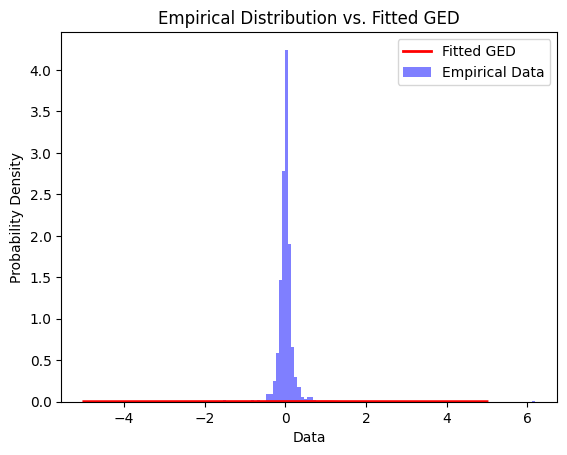

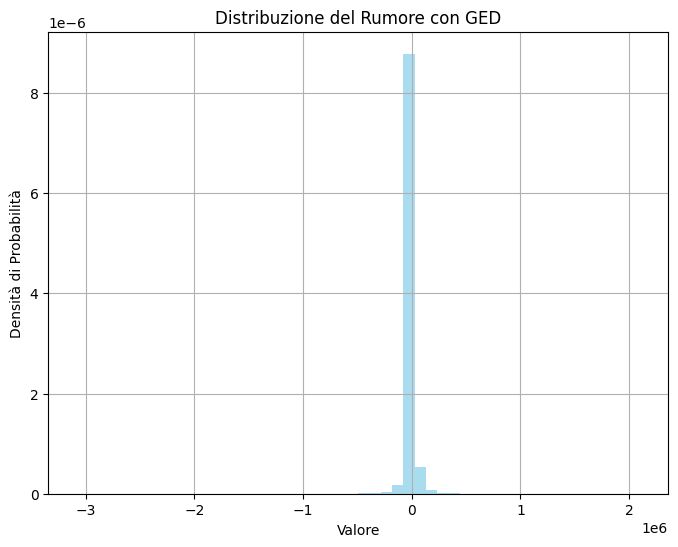

In [9]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import gennorm
def gamma_torch(x):
    return torch.exp(torch.lgamma(x))

# Definire la funzione della distribuzione GED
def gennorm_pdf(x, beta, loc, scale):
    return (beta / (2 * scale * gamma_torch(1 / beta))) * torch.exp(-torch.abs((x - loc) / scale) ** beta)

data = df
prices = data['close']#.values
log_returns = prices.pct_change().dropna().values*100
data =log_returns

# Inizializzazione del modello, dell'ottimizzatore e della funzione di perdita
beta = torch.tensor(0.2, requires_grad=True)
loc = torch.tensor(1.1, requires_grad=True)
scale = torch.tensor(1.1, requires_grad=True)
optimizer = optim.Adam([beta, loc, scale], lr=0.005)

# Addestramento del modello con più batch
batch_size = 3000
num_batches = len(data) // batch_size

epochs = 3050

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        batch_data = torch.tensor(data[start_idx:end_idx], dtype=torch.float32)

        optimizer.zero_grad()
        loss = -torch.mean(torch.log(gennorm_pdf(batch_data, beta, loc, scale)))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

# Calcola i parametri stimati
beta_estimated = beta.item()
loc_estimated = loc.item()
scale_estimated = scale.item()

# Stampa i risultati
print(f'Parametri stimati (beta, loc, scale): {beta_estimated:.4f}, {loc_estimated:.4f}, {scale_estimated:.4f}')

x = np.linspace(-5, 5, 1000)
pdf_values = gennorm_pdf(torch.tensor(x, dtype=torch.float32), torch.tensor(beta_estimated), torch.tensor(loc_estimated), torch.tensor(scale_estimated)).detach().numpy()

plt.plot(x, pdf_values, 'r-', lw=2, label='Fitted GED')
plt.hist(data, bins=100, density=True, alpha=0.5, color='b', label='Empirical Data')
plt.xlabel('Data')
plt.ylabel('Probability Density')
plt.title('Empirical Distribution vs. Fitted GED')
plt.legend()

plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gennorm

ged_noise = gennorm.rvs(beta_estimated, loc_estimated, scale_estimated, size=10000)
plt.figure(figsize=(8, 6))
plt.hist(ged_noise, bins=50, density=True, color='skyblue', alpha=0.7)
plt.title('Distribuzione del Rumore con GED')
plt.xlabel('Valore')
plt.ylabel('Densità di Probabilità')
plt.grid(True)
plt.show()

In [10]:
#BROWNIAN GAUSSIAN

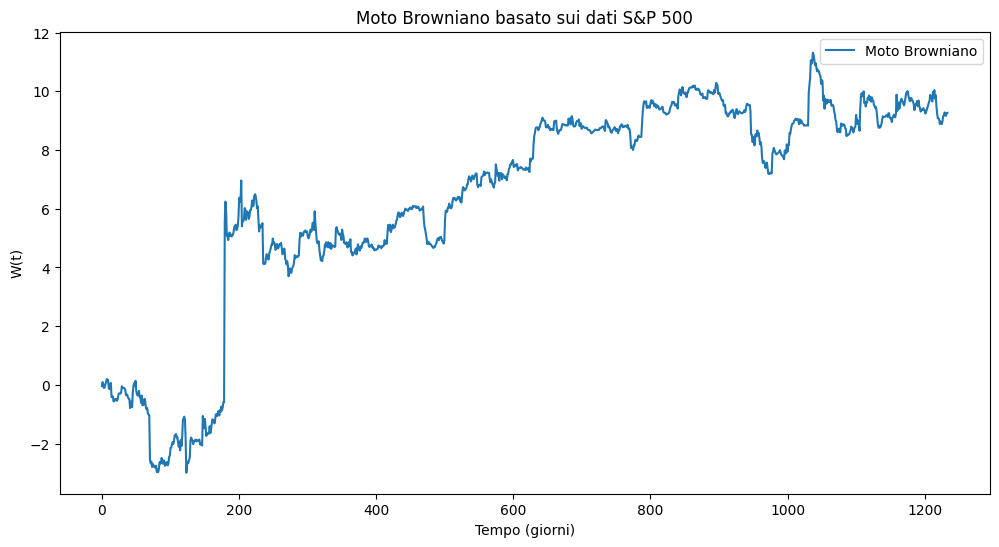

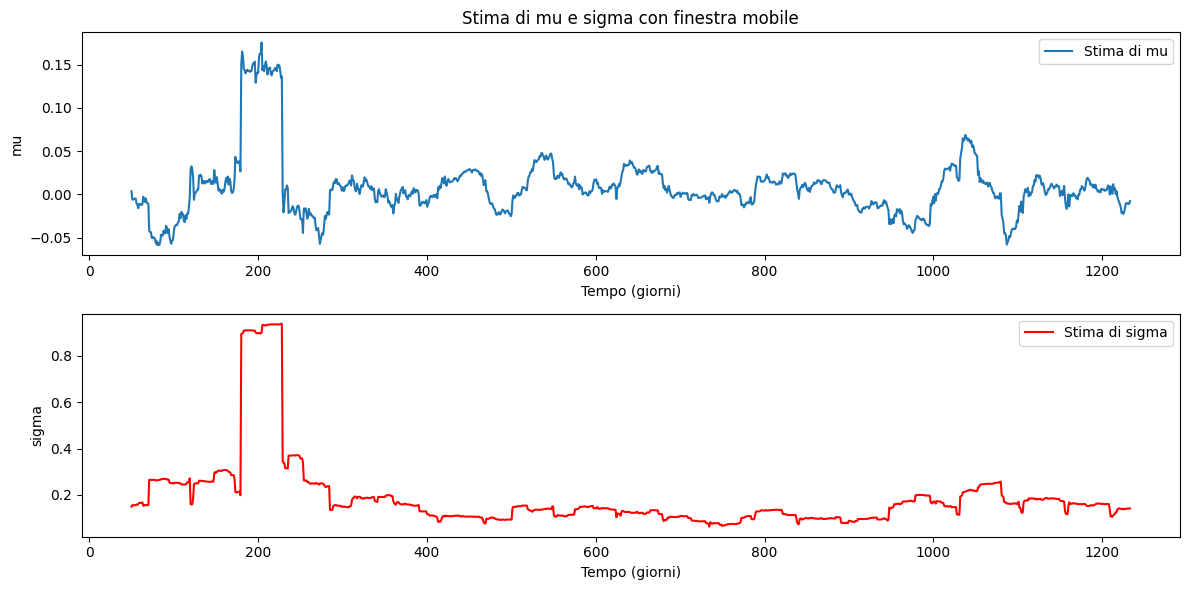

Stima media di mu: 0.0082
Stima media di sigma: 0.1888


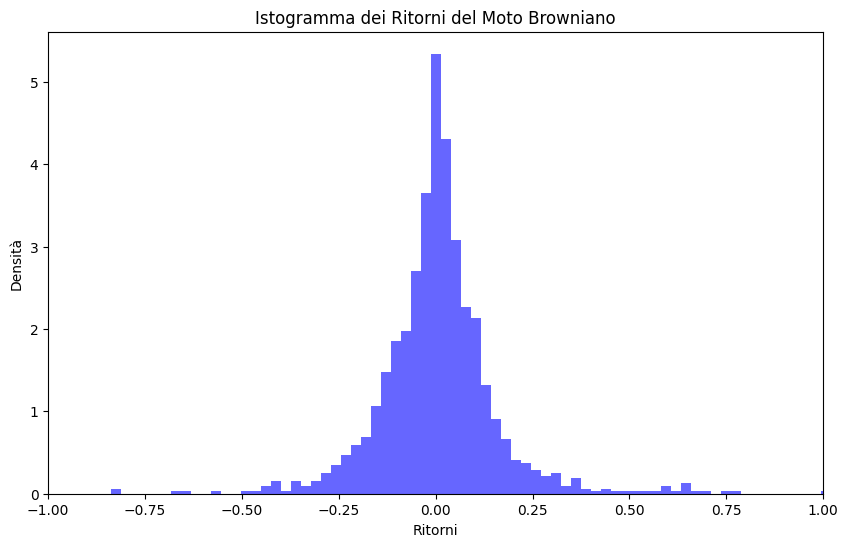

In [11]:
#Scarica i dati del S&P 500 da Yahoo Finance
data = df
prices = data['close']#.values

# Calcola i rendimenti logaritmici giornalieri
log_returns = prices.pct_change().dropna().values*100

# Parametri del moto browniano
dt = 1  # 1 giorno devi rifare tutto il devi rifare tutto il
num_steps = len(log_returns)

# Generazione del processo di moto browniano
t = np.linspace(0, num_steps*dt, num_steps)
W = np.cumsum(log_returns)

plt.figure(figsize=(12, 6))
plt.plot(t, W, label="Moto Browniano")
plt.title("Moto Browniano basato sui dati S&P 500")
plt.xlabel("Tempo (giorni)")
plt.ylabel("W(t)")
plt.legend()
plt.show()

# Funzione di log-likelihood
def log_likelihood(params, data, dt):
    mu, sigma = params
    diff = np.diff(data)
    ll = -0.5 * len(diff) * np.log(2 * np.pi * sigma**2) - 0.5 * np.sum((diff - mu * dt)**2) / sigma**2
    return -ll

# Calcola la media e la varianza mobile negli ultimi 20 steps
window = 50
mu_estimates = []
sigma_estimates = []

for i in range(window, num_steps):
    window_data = W[i-window:i]
    initial_guess = [np.mean(window_data), np.std(window_data)]
    result = minimize(log_likelihood, initial_guess, args=(window_data, dt), bounds=[(-2, 2), (1e-4, 3)])
    mu_est, sigma_est = result.x
    mu_estimates.append(mu_est)
    sigma_estimates.append(sigma_est)

# Plot delle stime
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[window:], mu_estimates, label="Stima di mu")
plt.title("Stima di mu e sigma con finestra mobile")
plt.xlabel("Tempo (giorni)")
plt.ylabel("mu")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[window:], sigma_estimates, label="Stima di sigma", color='r')
plt.xlabel("Tempo (giorni)")
plt.ylabel("sigma")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Stima media di mu: {np.mean(mu_estimates):.4f}")
print(f"Stima media di sigma: {np.mean(sigma_estimates):.4f}")

plt.figure(figsize=(10, 6))
plt.xlim(-1, 1)
plt.hist(log_returns , bins=300, density=True, alpha=0.6, color='b')
plt.title('Istogramma dei Ritorni del Moto Browniano')
plt.xlabel('Ritorni')
plt.ylabel('Densità')
plt.show()

In [12]:
'''import pandas as pd
import matplotlib.pyplot as plt

estimates = pd.DataFrame({
    'time': t[window:],
    'mu_estimate': mu_estimates,
    'sigma_estimate': sigma_estimates
})
# La variabile 'estimates' è già disponibile in memoria dalla prima cella
# Carica i dati dei prezzi originali
prices = prices.iloc[window:].reset_index(drop=True)

# Parametro soglia per mu
threshold =-0.01

# Genera segnali di trading e calcola i rendimenti della strategia
signals = []
returns_strategy = []
leverage = 5
position = 0  # 0 = no position, 1 = long position

for i, mu_est in enumerate(estimates['mu_estimate']):
    if mu_est < threshold and position == 0:
        signals.append('buy')
        position = 1
        returns_strategy.append(leverage * log_returns[window + i])  # leva 5
    elif mu_est >= 0.02 and position == 1:
        signals.append('sell')
        position = 0
        returns_strategy.append(0)
    else:
        signals.append('hold')
        if position == 1:
            returns_strategy.append(leverage * log_returns[window + i])
        else:
            returns_strategy.append(0)

# Calcola i rendimenti cumulativi della strategia e del buy and hold
cumulative_returns_strategy = np.cumsum(returns_strategy)
cumulative_returns_bh = np.cumsum(log_returns[window:])

# Plot dei rendimenti cumulativi
plt.figure(figsize=(12, 6))
plt.plot(estimates['time'], cumulative_returns_strategy, label='Strategia con Leva 5')
plt.plot(estimates['time'], cumulative_returns_bh, label='Buy and Hold', linestyle='--')
plt.title('Confronto tra Strategia con Leva 5 e Buy and Hold')
plt.xlabel('Tempo (giorni)')
plt.ylabel('Rendimenti Cumulativi (%)')
plt.legend()
plt.show()'''




"import pandas as pd\nimport matplotlib.pyplot as plt\n\nestimates = pd.DataFrame({\n    'time': t[window:],\n    'mu_estimate': mu_estimates,\n    'sigma_estimate': sigma_estimates\n})\n# La variabile 'estimates' è già disponibile in memoria dalla prima cella\n# Carica i dati dei prezzi originali\nprices = prices.iloc[window:].reset_index(drop=True)\n\n# Parametro soglia per mu\nthreshold =-0.01\n\n# Genera segnali di trading e calcola i rendimenti della strategia\nsignals = []\nreturns_strategy = []\nleverage = 5\nposition = 0  # 0 = no position, 1 = long position\n\nfor i, mu_est in enumerate(estimates['mu_estimate']):\n    if mu_est < threshold and position == 0:\n        signals.append('buy')\n        position = 1\n        returns_strategy.append(leverage * log_returns[window + i])  # leva 5\n    elif mu_est >= 0.02 and position == 1:\n        signals.append('sell')\n        position = 0\n        returns_strategy.append(0)\n    else:\n        signals.append('hold')\n        if pos

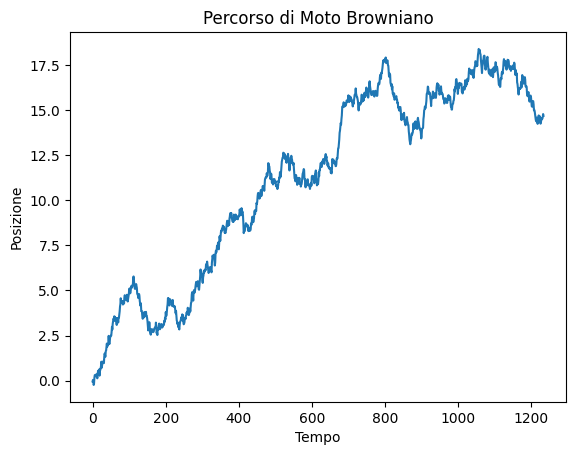

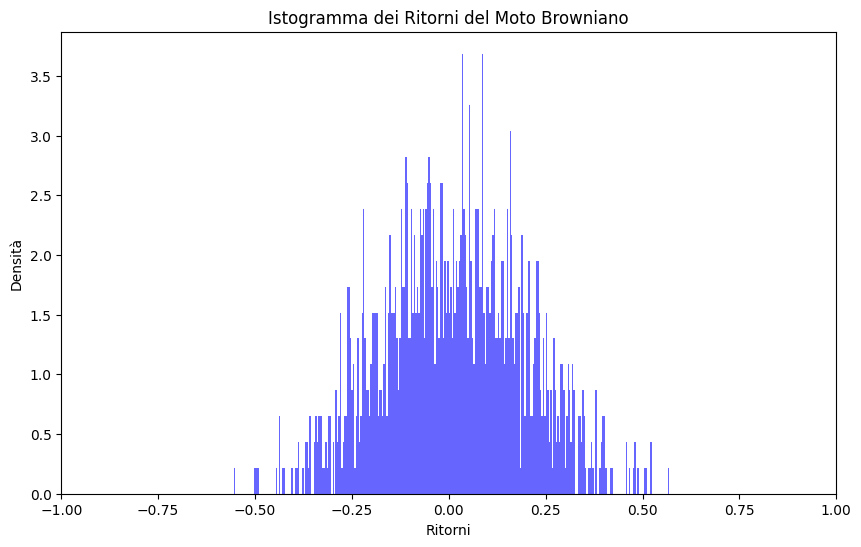

In [13]:
# Parametri
mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard
T = len(log_returns )  # Tempo totale
N = len(log_returns )  # Numero di passi
dt = 1#(T / N)  # Intervallo di tempo
t = np.linspace(0, T, N)
dW = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt), size=N)
W = np.cumsum(dW)
# Plot del percorso di moto browniano
plt.plot(t, W)
plt.title('Percorso di Moto Browniano')
plt.xlabel('Tempo')
plt.ylabel('Posizione')
plt.show()
# Ritorni
returns = np.diff(W)
# Plot dell'istogramma dei ritorni
plt.figure(figsize=(10, 6))
plt.xlim(-1, 1)
plt.hist(returns, bins=300, density=True, alpha=0.6, color='b')
plt.title('Istogramma dei Ritorni del Moto Browniano')
plt.xlabel('Ritorni')
plt.ylabel('Densità')
plt.show()

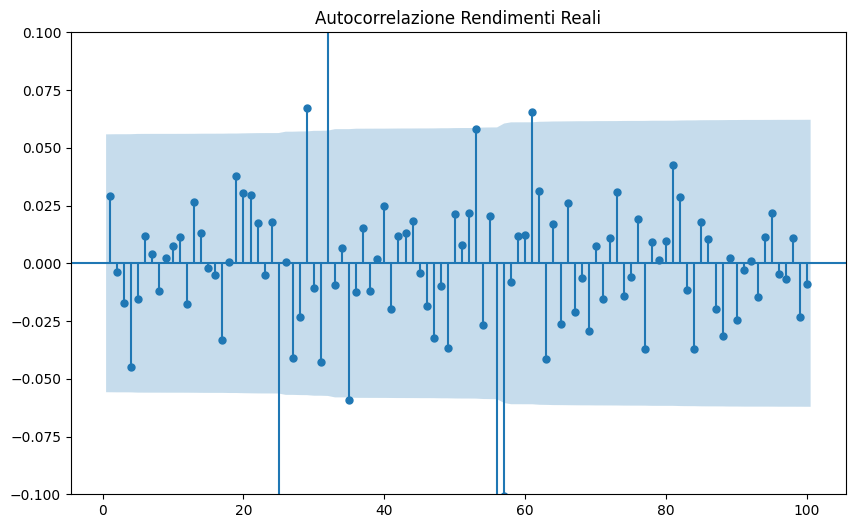

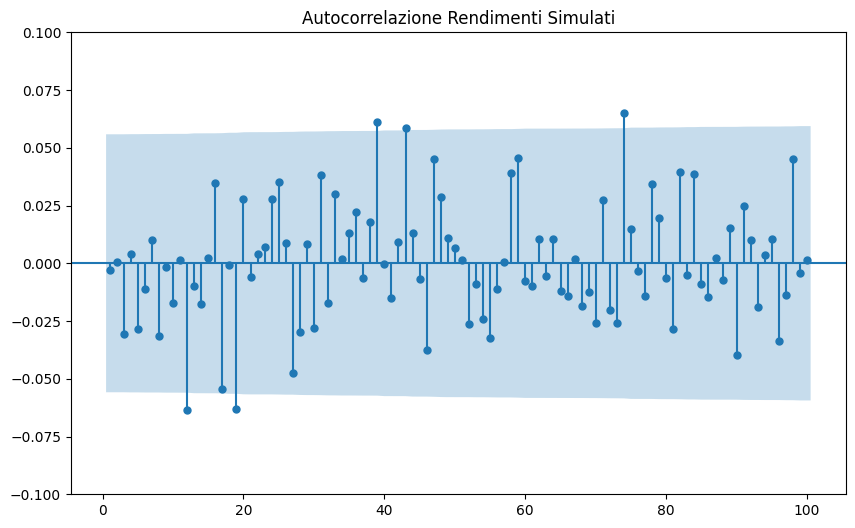

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

# Calcola l'autocorrelazione dei rendimenti reali
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(log_returns , lags=100, ax=ax, title='Autocorrelazione Rendimenti Reali', zero=False)
ax.set_ylim(-0.1, 0.1)  # Imposta i limiti sull'asse y
plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(returns , lags=100, ax=ax, title='Autocorrelazione Rendimenti Simulati', zero=False)
ax.set_ylim(-0.1, 0.1)  # Imposta i limiti sull'asse y
plt.show()

In [16]:
#caso gaussiano

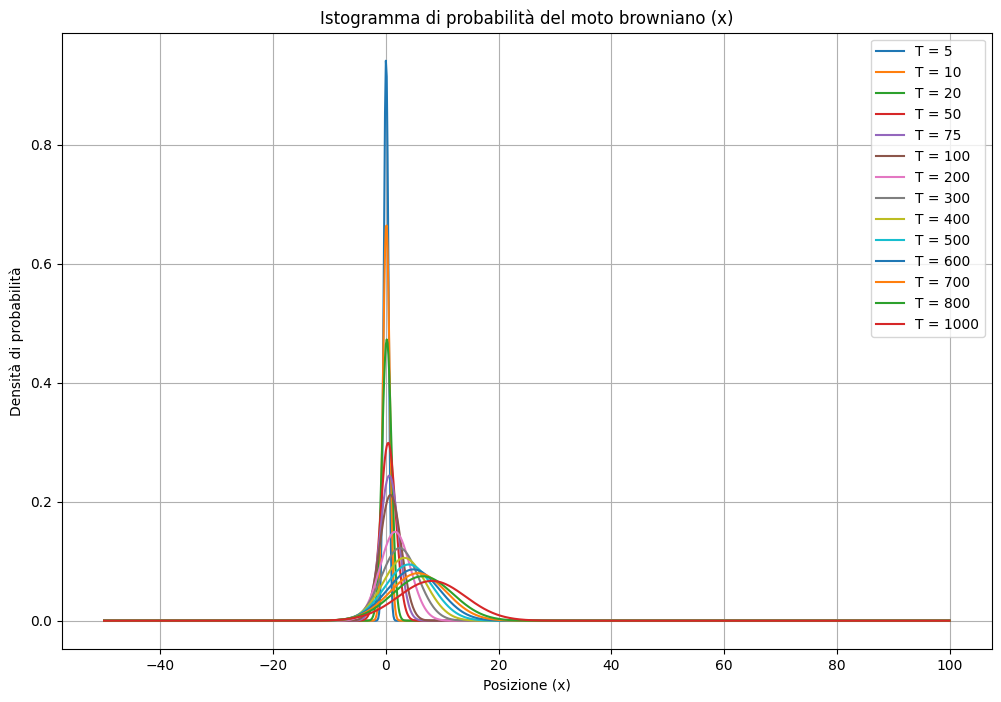

In [22]:
# Valori di T da considerare
def brownian_probability_density(x, t, mu, sigma):
    """
    Calcola la densità di probabilità del moto browniano utilizzando l'equazione di Fokker-Planck.

    Argomenti:
    x : float o array
        Posizione.
    t : float
        Tempo.
    mu : float
        Tasso di drift.
    sigma : float
        Deviazione standard.

    Ritorna:
    float o array
        Densità di probabilità del moto browniano al tempo t e posizione x.
    """
    coefficient = 1 / np.sqrt(2 * np.pi * sigma**2 * t)
    exponent = -((x - mu * t)**2) / (2 * sigma**2 * t)
    return coefficient * np.exp(exponent)

# Parametri del modello
mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard
T = len(log_returns )  # Tempo totale
N = len(log_returns )  # Numero di passi
dt = T / N  # Intervallo di tempo

# Livello di take profit
x_tp = 0.05  # Esempio: 105% del prezzo iniziale

# Tempo
t = np.linspace(1, T, N)
T_values = [5,10,20,50,75,100,200,300,400,500,600,700,800,1000]

# Numero di bin per l'istogramma
num_bins = 1000

plt.figure(figsize=(12, 8))

for T in T_values:
    # Calcolo della distribuzione di probabilità
    t = T  # Scegliamo un singolo istante di tempo
    x_values = np.linspace(-50, 100, 1000)  # Valori di posizione da considerare
    P = brownian_probability_density(x_values, t, mu, sigma)

    # Calcolo dell'istogramma
    hist, bins = np.histogram(x_values, bins=num_bins, weights=P, density=True)
    bin_centers = (bins[1:] + bins[:-1]) / 2

    # Plot dell'istogramma
    plt.plot(bin_centers, hist, label=f'T = {T}')

plt.title('Istogramma di probabilità del moto browniano (x)')
plt.xlabel('Posizione (x)')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.show()

In [23]:


# Parametri del processo
'''mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard
M = 1000  # Numero di passi massimi
N = 2000 # Numero di simulazioni

# Numero di combinazioni da generare
num_combinations = 100

# Generazione di combinazioni casuali di livelli di interesse e stop loss
np.random.seed(43)  # Imposta il seed per la riproducibilità
levels_of_interest = np.random.uniform(0.001, 1, num_combinations)
levels_of_interest_stop_loss = np.random.uniform(-1, -0.001, num_combinations)

# Simulazione e plot delle probabilità per ogni combinazione
plt.figure()
for i in range(num_combinations):
    # Simulazione del moto browniano con drift per il livello di interesse
    simulated_prices_interest = np.zeros((N, M+1))
    for j in range(N):
        prices = np.zeros(M+1)
        for t in range(1, M+1):
            prices[t] = prices[t-1] + mu + sigma * np.random.normal()
            # Verifica se il prezzo supera il livello di interesse dopo t passi
            if prices[t] > levels_of_interest[i]:
                simulated_prices_interest[j, t+1:] = 1
                break

    # Calcolo della probabilità che il prezzo superi il livello di interesse dopo un certo numero di passi
    probability_of_exceeding_level = np.mean(simulated_prices_interest, axis=0)

    # Simulazione del moto browniano con drift per il livello di stop loss
    simulated_prices_stop_loss = np.zeros((N, M+1))
    for j in range(N):
        prices = np.zeros(M+1)
        for t in range(1, M+1):
            prices[t] = prices[t-1] + mu + sigma * np.random.normal()
            # Verifica se il prezzo supera il livello di stop loss dopo t passi
            if prices[t] < levels_of_interest_stop_loss[i]:
                simulated_prices_stop_loss[j, t+1:] = 1
                break

    # Calcolo della probabilità che il prezzo superi il livello di stop loss dopo un certo numero di passi
    probability_of_exceeding_level_stop_loss = np.mean(simulated_prices_stop_loss, axis=0)

    # Plot delle probabilità per la combinazione corrente
    plt.plot(range(M+1), probability_of_exceeding_level, label=f'Take profit: {levels_of_interest[i]:.2f}%')
    plt.plot(range(M+1), probability_of_exceeding_level_stop_loss, label=f'Stop Loss: {levels_of_interest_stop_loss[i]:.2f}%')

plt.xlabel('Numero di passi')
plt.ylabel('Probabilità')
plt.title('Probabilità di superare il livello di interesse o il livello di stop loss dopo un numero di passi')
plt.legend(title='Livello di prezzo')
plt.grid(True)
plt.show()'''



"mu = np.mean(mu_estimates)  # Stima media\nsigma = np.mean(sigma_estimates)  # Stima deviazione standard\nM = 1000  # Numero di passi massimi\nN = 2000 # Numero di simulazioni\n\n# Numero di combinazioni da generare\nnum_combinations = 100\n\n# Generazione di combinazioni casuali di livelli di interesse e stop loss\nnp.random.seed(43)  # Imposta il seed per la riproducibilità\nlevels_of_interest = np.random.uniform(0.001, 1, num_combinations)\nlevels_of_interest_stop_loss = np.random.uniform(-1, -0.001, num_combinations)\n\n# Simulazione e plot delle probabilità per ogni combinazione\nplt.figure()\nfor i in range(num_combinations):\n    # Simulazione del moto browniano con drift per il livello di interesse\n    simulated_prices_interest = np.zeros((N, M+1))\n    for j in range(N):\n        prices = np.zeros(M+1)\n        for t in range(1, M+1):\n            prices[t] = prices[t-1] + mu + sigma * np.random.normal()\n            # Verifica se il prezzo supera il livello di interesse dop

In [24]:
#generalized

In [32]:
N = 100  # Numero di simulazioni
num_combinations =100 # Numero di combinazioni da generare
Ms = list(range(1, 300, 10))  # Lista dei valori di M (finestra) da testare da 1 a 500 saltando di 5 in 5

<ipython-input-34-3089a56cabf0>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[t] = prices[t-1] + gennorm.rvs(beta_estimated, loc_estimated, scale_estimated, size=1)


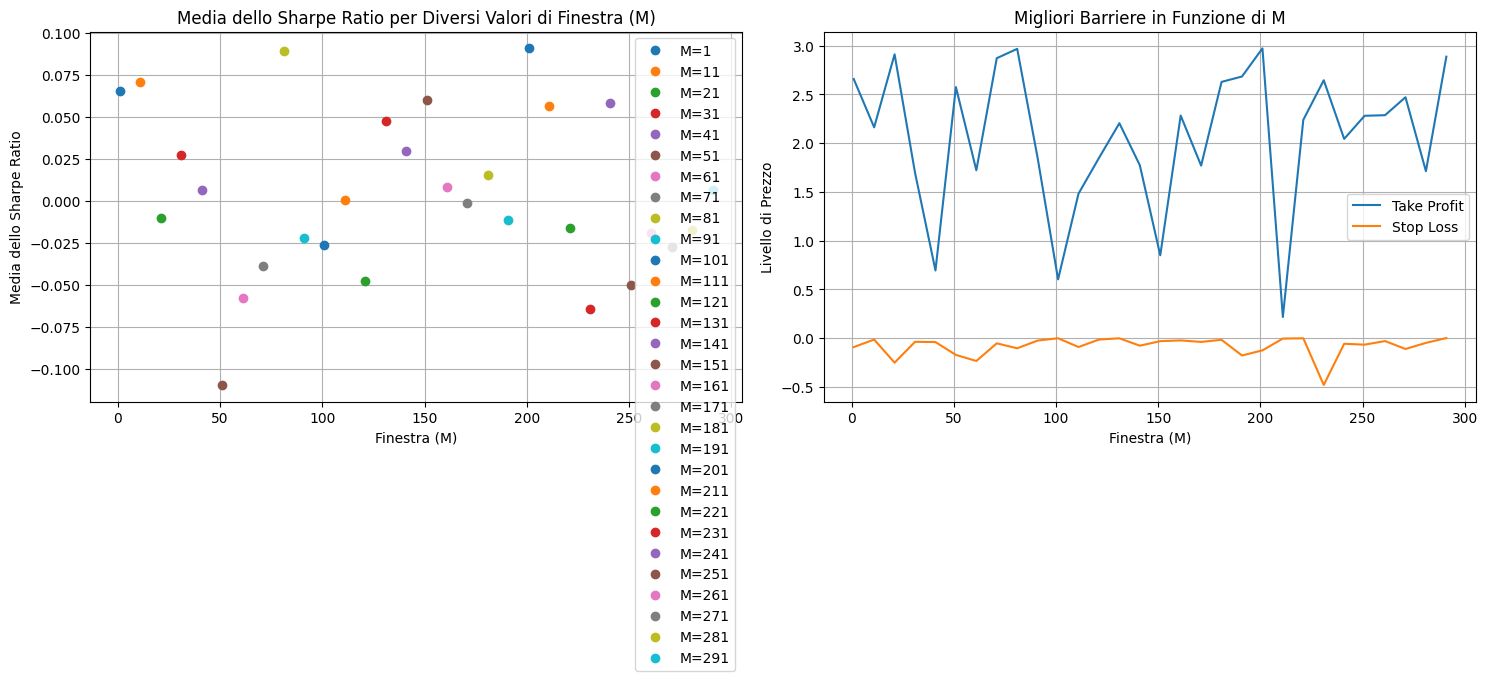

Per M=1: Take Profit=2.6578, Stop Loss=-0.0938
Per M=11: Take Profit=2.1618, Stop Loss=-0.0165
Per M=21: Take Profit=2.9114, Stop Loss=-0.2537
Per M=31: Take Profit=1.6958, Stop Loss=-0.0398
Per M=41: Take Profit=0.6926, Stop Loss=-0.0422
Per M=51: Take Profit=2.5749, Stop Loss=-0.1741
Per M=61: Take Profit=1.7211, Stop Loss=-0.2364
Per M=71: Take Profit=2.8716, Stop Loss=-0.0552
Per M=81: Take Profit=2.9674, Stop Loss=-0.1063
Per M=91: Take Profit=1.8475, Stop Loss=-0.0267
Per M=101: Take Profit=0.6014, Stop Loss=-0.0034
Per M=111: Take Profit=1.4813, Stop Loss=-0.0928
Per M=121: Take Profit=1.8469, Stop Loss=-0.0167
Per M=131: Take Profit=2.2041, Stop Loss=-0.0037
Per M=141: Take Profit=1.7728, Stop Loss=-0.0795
Per M=151: Take Profit=0.8484, Stop Loss=-0.0328
Per M=161: Take Profit=2.2825, Stop Loss=-0.0254
Per M=171: Take Profit=1.7690, Stop Loss=-0.0405
Per M=181: Take Profit=2.6281, Stop Loss=-0.0192
Per M=191: Take Profit=2.6835, Stop Loss=-0.1801
Per M=201: Take Profit=2.9722, 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [34]:
np.random.seed(43)
def find_optimal_combination(mu, sigma, M, N, num_combinations):
    # Generazione di combinazioni casuali di livelli di interesse e stop loss
      # Imposta il seed per la riproducibilità
    levels_of_interest = np.random.uniform(0.001, 3, num_combinations)
    levels_of_interest_stop_loss = np.random.uniform(-3, -0.001, num_combinations)
    # Simulazione e calcolo dei rendimenti e dei rischi
    sharpe_ratios = []
    optimal_combinations = []
    for i in range(num_combinations):
        total_returns = []
        for _ in range(N):
            prices = np.zeros(M + 1)
            for t in range(1, M + 1):
                prices[t] = prices[t-1] + gennorm.rvs(beta_estimated, loc_estimated, scale_estimated, size=1)
                if prices[t] > levels_of_interest[i]:
                    total_returns.append(levels_of_interest[i])
                    break
                elif prices[t] < levels_of_interest_stop_loss[i]:
                    total_returns.append(levels_of_interest_stop_loss[i])
                    break
            else:
                total_returns.append(prices[-1])

        total_returns = np.array(total_returns)
        expected_return = np.mean(total_returns)
        risk = np.std(total_returns)
        sharpe_ratio = expected_return / risk
        sharpe_ratios.append(sharpe_ratio)
        optimal_combinations.append((levels_of_interest[i], levels_of_interest_stop_loss[i]))
    return sharpe_ratios, optimal_combinations

# Parametri del processo
mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard


# Trova e traccia lo Sharpe Ratio per ogni valore di M
best_barrier_levels = []
sharpe_ratios_list = []
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for M in Ms:
    sharpe_ratios, optimal_combinations = find_optimal_combination(mu, sigma, M, N, num_combinations)#[0]
    sharpe_ratios_list.append(sharpe_ratios)
    best_idx = np.argmax(sharpe_ratios)
    best_barrier_levels.append(optimal_combinations[best_idx])
    plt.plot(M, np.mean(sharpe_ratios), 'o', label=f'M={M}')


plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Media dello Sharpe Ratio per Diversi Valori di Finestra (M)')
plt.legend()
plt.grid(True)

best_take_profit_levels = [level[0] for level in best_barrier_levels]
best_stop_loss_levels = [level[1] for level in best_barrier_levels]

# Traccia le migliori barriere in funzione di M
plt.subplot(1, 2, 2)
plt.plot(Ms, best_take_profit_levels, label='Take Profit')
plt.plot(Ms, best_stop_loss_levels, label='Stop Loss')

plt.xlabel('Finestra (M)')
plt.ylabel('Livello di Prezzo')
plt.title('Migliori Barriere in Funzione di M')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

for M, take_profit, stop_loss in zip(Ms, best_take_profit_levels, best_stop_loss_levels):
    print(f"Per M={M}: Take Profit={take_profit:.4f}, Stop Loss={stop_loss:.4f}")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sharpe_ratio_mean = np.mean(sharpe_ratios_list, axis=1)

# Funzione logistica
def logistic_function(M, L, k, M0):
    return L / (1 + np.exp(-k * (M - M0)))

# Fitting della funzione logistica ai dati
popt, pcov = curve_fit(logistic_function, Ms, sharpe_ratio_mean, p0=[1, 0.1, 100])

# Estrazione dei parametri ottimali
L_fit, k_fit, M0_fit = popt

# Generazione dei dati fittati
M_fit = np.linspace(min(Ms), max(Ms), 500)
sharpe_ratios_fit = logistic_function(M_fit, L_fit, k_fit, M0_fit)

# Prima derivata
def logistic_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k * exp_term) / ((1 + exp_term) ** 2)

# Seconda derivata
def logistic_second_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k**2 * exp_term * (exp_term - 1)) / ((1 + exp_term) ** 3)

# Calcolo delle derivate
sharpe_ratios_derivative = logistic_derivative(M_fit, L_fit, k_fit, M0_fit)
sharpe_ratios_second_derivative = logistic_second_derivative(M_fit, L_fit, k_fit, M0_fit)

# Punto di inflessione
inflection_point = M0_fit

# Tracciamento dei risultati
plt.figure(figsize=(12, 8))

# Funzione logistica
plt.subplot(3, 1, 1)
plt.plot(Ms, sharpe_ratio_mean, 'o', label='Dati empirici')
plt.plot(M_fit, sharpe_ratios_fit, '-', label='Fitting logistica')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Fitting di una funzione logistica sui dati empirici')
plt.legend()
plt.grid(True)

# Prima derivata
plt.subplot(3, 1, 2)
plt.plot(M_fit, sharpe_ratios_derivative, '-', label='Prima derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Prima derivata')
plt.legend()
plt.grid(True)

# Seconda derivata
plt.subplot(3, 1, 3)
plt.plot(M_fit, sharpe_ratios_second_derivative, '-', label='Seconda derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Seconda derivata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampa dei parametri fittati
print(f"L fit: {L_fit}")
print(f"k fit: {k_fit}")
print(f"M0 fit (punto di inflessione): {M0_fit}")
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(43)
def find_optimal_combination(mu, sigma, M, N, num_combinations):
    # Generazione di combinazioni casuali di livelli di interesse e stop loss per short
    levels_of_interest = np.random.uniform(-3, -0.001, num_combinations)
    levels_of_interest_stop_loss = np.random.uniform(0.001, 3, num_combinations)
    # Simulazione e calcolo dei rendimenti e dei rischi
    sharpe_ratios = []
    optimal_combinations = []
    for i in range(num_combinations):
        total_returns = []
        for _ in range(N):
            prices = np.zeros(M + 1)
            for t in range(1, M + 1):
                prices[t] = prices[t-1] + gennorm.rvs(beta_estimated, loc_estimated, scale_estimated, size=1)
                if prices[t] < levels_of_interest[i]:
                    total_returns.append(-levels_of_interest[i])
                    break
                elif prices[t] > levels_of_interest_stop_loss[i]:
                    total_returns.append(-levels_of_interest_stop_loss[i])
                    break
            else:
                total_returns.append(prices[-1])

        total_returns = np.array(total_returns)
        expected_return = np.mean(total_returns)
        risk = np.std(total_returns)
        sharpe_ratio = expected_return / risk
        sharpe_ratios.append(sharpe_ratio)
        optimal_combinations.append((levels_of_interest[i], levels_of_interest_stop_loss[i]))
    return sharpe_ratios, optimal_combinations



N = 100  # Numero di simulazioni
num_combinations =100 # Numero di combinazioni da generare
Ms = list(range(1, 300, 10))  # Lista dei valori di M (finestra) da testare da 1 a 500 saltando di 5 in 5
# Parametri del processo

mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard


# Trova e traccia lo Sharpe Ratio per ogni valore di M
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
best_barrier_levels = []
sharpe_ratios_list = []
for M in Ms:
    sharpe_ratios, optimal_combinations = find_optimal_combination(mu, sigma, M, N, num_combinations)#[0]
    sharpe_ratios_list.append(sharpe_ratios)
    best_idx = np.argmax(sharpe_ratios)
    best_barrier_levels.append(optimal_combinations[best_idx])
    plt.plot(M, np.mean(sharpe_ratios), 'o', label=f'M={M}')

plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Media dello Sharpe Ratio per Diversi Valori di Finestra (M)')
plt.legend()
plt.grid(True)

# Trova le migliori barriere per ogni valore di M


best_take_profit_levels = [level[0] for level in best_barrier_levels]
best_stop_loss_levels = [level[1] for level in best_barrier_levels]

# Traccia le migliori barriere in funzione di M
plt.subplot(1, 2, 2)
plt.plot(Ms, best_take_profit_levels, label='Take Profit')
plt.plot(Ms, best_stop_loss_levels, label='Stop Loss')

plt.xlabel('Finestra (M)')
plt.ylabel('Livello di Prezzo')
plt.title('Migliori Barriere in Funzione di M')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
for M, take_profit, stop_loss in zip(Ms, best_take_profit_levels, best_stop_loss_levels):
    print(f"Per M={M}: Take Profit={take_profit:.4f}, Stop Loss={stop_loss:.4f}")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sharpe_ratio_mean = np.mean(sharpe_ratios_list, axis=1)

# Funzione logistica
def logistic_function(M, L, k, M0):
    return L / (1 + np.exp(-k * (M - M0)))

# Fitting della funzione logistica ai dati
popt, pcov = curve_fit(logistic_function, Ms, sharpe_ratio_mean, p0=[1, 0.1, 100])

# Estrazione dei parametri ottimali
L_fit, k_fit, M0_fit = popt

# Generazione dei dati fittati
M_fit = np.linspace(min(Ms), max(Ms), 500)
sharpe_ratios_fit = logistic_function(M_fit, L_fit, k_fit, M0_fit)

# Prima derivata
def logistic_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k * exp_term) / ((1 + exp_term) ** 2)

# Seconda derivata
def logistic_second_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k**2 * exp_term * (exp_term - 1)) / ((1 + exp_term) ** 3)

# Calcolo delle derivate
sharpe_ratios_derivative = logistic_derivative(M_fit, L_fit, k_fit, M0_fit)
sharpe_ratios_second_derivative = logistic_second_derivative(M_fit, L_fit, k_fit, M0_fit)

# Punto di inflessione
inflection_point = M0_fit

# Tracciamento dei risultati
plt.figure(figsize=(12, 8))

# Funzione logistica
plt.subplot(3, 1, 1)
plt.plot(Ms, sharpe_ratio_mean, 'o', label='Dati empirici')
plt.plot(M_fit, sharpe_ratios_fit, '-', label='Fitting logistica')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Fitting di una funzione logistica sui dati empirici')
plt.legend()
plt.grid(True)

# Prima derivata
plt.subplot(3, 1, 2)
plt.plot(M_fit, sharpe_ratios_derivative, '-', label='Prima derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Prima derivata')
plt.legend()
plt.grid(True)

# Seconda derivata
plt.subplot(3, 1, 3)
plt.plot(M_fit, sharpe_ratios_second_derivative, '-', label='Seconda derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Seconda derivata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampa dei parametri fittati
print(f"L fit: {L_fit}")
print(f"k fit: {k_fit}")
print(f"M0 fit (punto di inflessione): {M0_fit}")

In [ ]:
#gaussian

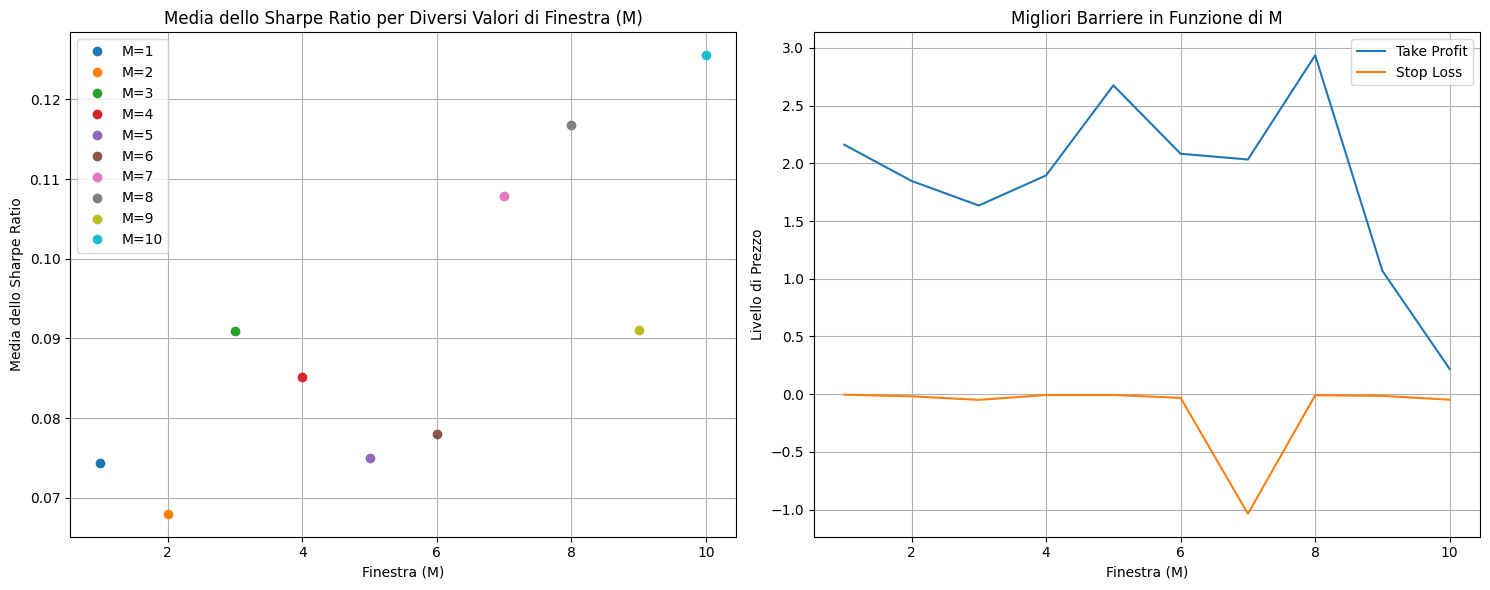

Per M=1: Take Profit=2.1607, Stop Loss=-0.0048
Per M=2: Take Profit=1.8471, Stop Loss=-0.0191
Per M=3: Take Profit=1.6340, Stop Loss=-0.0497
Per M=4: Take Profit=1.8952, Stop Loss=-0.0076
Per M=5: Take Profit=2.6753, Stop Loss=-0.0077
Per M=6: Take Profit=2.0827, Stop Loss=-0.0326
Per M=7: Take Profit=2.0329, Stop Loss=-1.0370
Per M=8: Take Profit=2.9362, Stop Loss=-0.0098
Per M=9: Take Profit=1.0672, Stop Loss=-0.0150
Per M=10: Take Profit=0.2172, Stop Loss=-0.0485


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [35]:
np.random.seed(43)
def find_optimal_combination(mu, sigma, M, N, num_combinations):
    # Generazione di combinazioni casuali di livelli di interesse e stop loss
      # Imposta il seed per la riproducibilità
    levels_of_interest = np.random.uniform(0.001, 3, num_combinations)
    levels_of_interest_stop_loss = np.random.uniform(-3, -0.001, num_combinations)
    # Simulazione e calcolo dei rendimenti e dei rischi
    sharpe_ratios = []
    optimal_combinations = []
    for i in range(num_combinations):
        total_returns = []
        for _ in range(N):
            prices = np.zeros(M + 1)
            for t in range(1, M + 1):
                prices[t] = prices[t-1] + mu + sigma * np.random.normal()
                if prices[t] > levels_of_interest[i]:
                    total_returns.append(levels_of_interest[i])
                    break
                elif prices[t] < levels_of_interest_stop_loss[i]:
                    total_returns.append(levels_of_interest_stop_loss[i])
                    break
            else:
                total_returns.append(prices[-1])

        total_returns = np.array(total_returns)
        expected_return = np.mean(total_returns)
        risk = np.std(total_returns)
        sharpe_ratio = expected_return / risk
        sharpe_ratios.append(sharpe_ratio)
        optimal_combinations.append((levels_of_interest[i], levels_of_interest_stop_loss[i]))
    return sharpe_ratios, optimal_combinations

# Parametri del processo
mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard
N = 100  # Numero di simulazioni
num_combinations =100 # Numero di combinazioni da generare
Ms = list(range(1, 11, 1))  # Lista dei valori di M (finestra) da testare da 1 a 500 saltando di 5 in 5

# Trova e traccia lo Sharpe Ratio per ogni valore di M
best_barrier_levels = []
sharpe_ratios_list = []
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for M in Ms:
    sharpe_ratios, optimal_combinations = find_optimal_combination(mu, sigma, M, N, num_combinations)#[0]
    sharpe_ratios_list.append(sharpe_ratios)
    best_idx = np.argmax(sharpe_ratios)
    best_barrier_levels.append(optimal_combinations[best_idx])
    plt.plot(M, np.mean(sharpe_ratios), 'o', label=f'M={M}')


plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Media dello Sharpe Ratio per Diversi Valori di Finestra (M)')
plt.legend()
plt.grid(True)

best_take_profit_levels = [level[0] for level in best_barrier_levels]
best_stop_loss_levels = [level[1] for level in best_barrier_levels]

# Traccia le migliori barriere in funzione di M
plt.subplot(1, 2, 2)
plt.plot(Ms, best_take_profit_levels, label='Take Profit')
plt.plot(Ms, best_stop_loss_levels, label='Stop Loss')

plt.xlabel('Finestra (M)')
plt.ylabel('Livello di Prezzo')
plt.title('Migliori Barriere in Funzione di M')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

for M, take_profit, stop_loss in zip(Ms, best_take_profit_levels, best_stop_loss_levels):
    print(f"Per M={M}: Take Profit={take_profit:.4f}, Stop Loss={stop_loss:.4f}")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sharpe_ratio_mean = np.mean(sharpe_ratios_list, axis=1)

# Funzione logistica
def logistic_function(M, L, k, M0):
    return L / (1 + np.exp(-k * (M - M0)))

# Fitting della funzione logistica ai dati
popt, pcov = curve_fit(logistic_function, Ms, sharpe_ratio_mean, p0=[1, 0.1, 100])

# Estrazione dei parametri ottimali
L_fit, k_fit, M0_fit = popt

# Generazione dei dati fittati
M_fit = np.linspace(min(Ms), max(Ms), 500)
sharpe_ratios_fit = logistic_function(M_fit, L_fit, k_fit, M0_fit)

# Prima derivata
def logistic_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k * exp_term) / ((1 + exp_term) ** 2)

# Seconda derivata
def logistic_second_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k**2 * exp_term * (exp_term - 1)) / ((1 + exp_term) ** 3)

# Calcolo delle derivate
sharpe_ratios_derivative = logistic_derivative(M_fit, L_fit, k_fit, M0_fit)
sharpe_ratios_second_derivative = logistic_second_derivative(M_fit, L_fit, k_fit, M0_fit)

# Punto di inflessione
inflection_point = M0_fit

# Tracciamento dei risultati
plt.figure(figsize=(12, 8))

# Funzione logistica
plt.subplot(3, 1, 1)
plt.plot(Ms, sharpe_ratio_mean, 'o', label='Dati empirici')
plt.plot(M_fit, sharpe_ratios_fit, '-', label='Fitting logistica')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Fitting di una funzione logistica sui dati empirici')
plt.legend()
plt.grid(True)

# Prima derivata
plt.subplot(3, 1, 2)
plt.plot(M_fit, sharpe_ratios_derivative, '-', label='Prima derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Prima derivata')
plt.legend()
plt.grid(True)

# Seconda derivata
plt.subplot(3, 1, 3)
plt.plot(M_fit, sharpe_ratios_second_derivative, '-', label='Seconda derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Seconda derivata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampa dei parametri fittati
print(f"L fit: {L_fit}")
print(f"k fit: {k_fit}")
print(f"M0 fit (punto di inflessione): {M0_fit}")
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(43)
def find_optimal_combination(mu, sigma, M, N, num_combinations):
    # Generazione di combinazioni casuali di livelli di interesse e stop loss per short
    levels_of_interest = np.random.uniform(-3, -0.001, num_combinations)
    levels_of_interest_stop_loss = np.random.uniform(0.001, 3, num_combinations)
    # Simulazione e calcolo dei rendimenti e dei rischi
    sharpe_ratios = []
    optimal_combinations = []
    for i in range(num_combinations):
        total_returns = []
        for _ in range(N):
            prices = np.zeros(M + 1)
            for t in range(1, M + 1):
                prices[t] = prices[t-1] + mu + sigma * np.random.normal()
                if prices[t] < levels_of_interest[i]:
                    total_returns.append(-levels_of_interest[i])
                    break
                elif prices[t] > levels_of_interest_stop_loss[i]:
                    total_returns.append(-levels_of_interest_stop_loss[i])
                    break
            else:
                total_returns.append(prices[-1])

        total_returns = np.array(total_returns)
        expected_return = np.mean(total_returns)
        risk = np.std(total_returns)
        sharpe_ratio = expected_return / risk
        sharpe_ratios.append(sharpe_ratio)
        optimal_combinations.append((levels_of_interest[i], levels_of_interest_stop_loss[i]))
    return sharpe_ratios, optimal_combinations


mu = np.mean(mu_estimates)  # Stima media
sigma = np.mean(sigma_estimates)  # Stima deviazione standard
N = 1000  # Numero di simulazioni
num_combinations = 900  # Numero di combinazioni da generare
Ms = list(range(1, 100, 10))  # Lista dei valori di M (finestra) da testare da 1 a 200 saltando di 10 in 10

# Trova e traccia lo Sharpe Ratio per ogni valore di M
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
best_barrier_levels = []
sharpe_ratios_list = []
for M in Ms:
    sharpe_ratios, optimal_combinations = find_optimal_combination(mu, sigma, M, N, num_combinations)#[0]
    sharpe_ratios_list.append(sharpe_ratios)
    best_idx = np.argmax(sharpe_ratios)
    best_barrier_levels.append(optimal_combinations[best_idx])
    plt.plot(M, np.mean(sharpe_ratios), 'o', label=f'M={M}')

plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Media dello Sharpe Ratio per Diversi Valori di Finestra (M)')
plt.legend()
plt.grid(True)

# Trova le migliori barriere per ogni valore di M


best_take_profit_levels = [level[0] for level in best_barrier_levels]
best_stop_loss_levels = [level[1] for level in best_barrier_levels]

# Traccia le migliori barriere in funzione di M
plt.subplot(1, 2, 2)
plt.plot(Ms, best_take_profit_levels, label='Take Profit')
plt.plot(Ms, best_stop_loss_levels, label='Stop Loss')

plt.xlabel('Finestra (M)')
plt.ylabel('Livello di Prezzo')
plt.title('Migliori Barriere in Funzione di M')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
for M, take_profit, stop_loss in zip(Ms, best_take_profit_levels, best_stop_loss_levels):
    print(f"Per M={M}: Take Profit={take_profit:.4f}, Stop Loss={stop_loss:.4f}")
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sharpe_ratio_mean = np.mean(sharpe_ratios_list, axis=1)

# Funzione logistica
def logistic_function(M, L, k, M0):
    return L / (1 + np.exp(-k * (M - M0)))

# Fitting della funzione logistica ai dati
popt, pcov = curve_fit(logistic_function, Ms, sharpe_ratio_mean, p0=[1, 0.1, 100])

# Estrazione dei parametri ottimali
L_fit, k_fit, M0_fit = popt

# Generazione dei dati fittati
M_fit = np.linspace(min(Ms), max(Ms), 500)
sharpe_ratios_fit = logistic_function(M_fit, L_fit, k_fit, M0_fit)

# Prima derivata
def logistic_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k * exp_term) / ((1 + exp_term) ** 2)

# Seconda derivata
def logistic_second_derivative(M, L, k, M0):
    exp_term = np.exp(-k * (M - M0))
    return (L * k**2 * exp_term * (exp_term - 1)) / ((1 + exp_term) ** 3)

# Calcolo delle derivate
sharpe_ratios_derivative = logistic_derivative(M_fit, L_fit, k_fit, M0_fit)
sharpe_ratios_second_derivative = logistic_second_derivative(M_fit, L_fit, k_fit, M0_fit)

# Punto di inflessione
inflection_point = M0_fit

# Tracciamento dei risultati
plt.figure(figsize=(12, 8))

# Funzione logistica
plt.subplot(3, 1, 1)
plt.plot(Ms, sharpe_ratio_mean, 'o', label='Dati empirici')
plt.plot(M_fit, sharpe_ratios_fit, '-', label='Fitting logistica')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Media dello Sharpe Ratio')
plt.title('Fitting di una funzione logistica sui dati empirici')
plt.legend()
plt.grid(True)

# Prima derivata
plt.subplot(3, 1, 2)
plt.plot(M_fit, sharpe_ratios_derivative, '-', label='Prima derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Prima derivata')
plt.legend()
plt.grid(True)

# Seconda derivata
plt.subplot(3, 1, 3)
plt.plot(M_fit, sharpe_ratios_second_derivative, '-', label='Seconda derivata')
plt.axvline(inflection_point, color='r', linestyle='--', label='Punto di inflessione')
plt.xlabel('Finestra (M)')
plt.ylabel('Seconda derivata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampa dei parametri fittati
print(f"L fit: {L_fit}")
print(f"k fit: {k_fit}")
print(f"M0 fit (punto di inflessione): {M0_fit}")